In [47]:
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
from typing import List
from typing import Union
from typing import Iterator
from typing import Optional
import re
import numpy as np
from functools import reduce
import ast
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from random import Random

from tvm import relay
from tvm.autotvm.graph_tuner.utils import expr2graph

import torch
from torch.utils.data import Dataset, Sampler
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, Optimizer
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR

In [48]:
op_names = [
"torch.Linear", "core.Reshape", "core.ReplicatePad ", "core.ReLU", 
"core.ExpandLast1", "core.Sub", "core.NCHWConv2d", "core.Tril", "core.Mul", 
"core.Clip", "core.Atan", "core.Squeeze", "core.ReduceMax", "core.Or", 
"core.NearestInterp", "core.ExpandLast4", "core.Conv1d", "core.Min", 
"None", "core.Max", "Concat ", "core.Transpose", "core.Round", "core.ArgMax", 
"core.Where", "core.GELU", "core.AvgPool2d", "core.Ceil", "core.BatchNorm2d", 
"Constant", "core.LeakyReLU", "core.Sigmoid", "core.ReduceMean", "core.Add", 
"core.Neg", "core.Triu", "core.TrilinearInterp", "core.Floor", "core.ArgMin", 
"core.Div", "core.Xor", "core.Slice ", "core.BilinearInterp", "core.LinearInterp", 
"core.Abs", "core.Equal", "core.ConstPad ", "torch.Flatten", "core.And", "Input", 
"Cast ", "torch.TorchReduceSum", "core.Cos", "core.ExpandLast2", "core.Softmax", 
"core.Sin", "core.MaxPool2d", "core.BicubicInterp", "core.Less", "core.PReLU", 
"core.ExpandLast3", "core.ReduceMin", "core.ReflectPad ", "core.Tan", "core.Greater",
"torch.PTMatMul"
]

data_type_names = [
    "i64", "i32", "b", "i8", "f64", "i16", "Unknow", "f32", "f16", "u8"
]

vocab = {op:  idx for idx, op in enumerate(op_names)}
op_vocab = {op: idx for idx, op in enumerate(op_names)}

# Load the dataset from the JSON file
json_filename = 'train_3000_3000.json'
with open(json_filename, 'r') as jsonfile:
    loaded_dataset_dicts = json.load(jsonfile)


# Extract the lists from the loaded dataset
node_info_set = [item['node_info'] for item in loaded_dataset_dicts]
edge_info_set = [item['edge_info'] for item in loaded_dataset_dicts]
graph_info_set = [item['graph_info'] for item in loaded_dataset_dicts]
result_set = [item['result'] for item in loaded_dataset_dicts]
count_result = 0
count_true_result = 0
for result in result_set:
    if result == 1:
        count_true_result += 1
    count_result += 1
print("在",count_result,"中有",count_true_result,"个触发bug")

def onek_encoding_unk(value: int, choices: List):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

def node_features(node_info:list):
    features = onek_encoding_unk(node_info[1], op_names)
    return features

def edge_features(edge_info:list):
    features = []
    for i in range(5):
        features.append(edge_info[2][i])
    tmp_list = onek_encoding_unk(edge_info[3], data_type_names)
    for i in range(len(tmp_list)):
        features.append(tmp_list[i])
    return features

def initialize_weights(model:nn.Module)->None:
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)

def convert_graph_data(node_info, edge_info):
    node_id_map = {}    # 用于映射节点ID的字典
    new_node_info = []
    new_edge_info = []
    for node_data in node_info:
        old_id = node_data[0]
        node_id_map[old_id] = len(node_id_map)  # 将旧节点ID映射为新的从0开始的ID
        new_node_data = [node_id_map[old_id]] + node_data[1:]
        new_node_info.append(new_node_data)

    for edge_data in edge_info:
        old_source_id, old_target_id = edge_data[0], edge_data[1]
        new_source_id = node_id_map[old_source_id]
        new_target_id = node_id_map[old_target_id]
        new_edge_data = [new_source_id, new_target_id] + edge_data[2:]
        new_edge_info.append(new_edge_data)

    return new_node_info, new_edge_info

def process_data(dataset_dicts):
    data_list = []

    for item in dataset_dicts:
        node_info = item['node_info']
        edge_info = item['edge_info']
        node_info, edge_info = convert_graph_data(node_info, edge_info)

        # 处理节点特征
        x = torch.tensor([node_features(ni) for ni in node_info], dtype=torch.float)

        # 处理边连接
        edge_index = torch.tensor([[e[0], e[1]] for e in edge_info], dtype=torch.long).t().contiguous()

        # 可以添加边的属性，如果有的话
        edge_attr = torch.tensor([edge_features(ei) for ei in edge_info], dtype=torch.float)

        # 结果标签
        y = torch.tensor([item['result']], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(data)

    return data_list

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: Optimizer,
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]

在 6000 中有 3000 个触发bug


In [49]:
adata = loaded_dataset_dicts[111]
node_info, edge_info = convert_graph_data(adata['node_info'], adata['edge_info'])
adata['node_info'], adata['edge_info'], node_info, edge_info

([[11, 'Input', 0],
  [12, 'core.Conv1d', 1],
  [6, 'Input', 0],
  [10, 'core.Ceil', 1],
  [7, 'core.Div', 2],
  [3, 'Input', 0],
  [5, 'core.Mul', 2],
  [1, 'core.ExpandLast4', 1],
  [2, 'core.MaxPool2d', 1],
  [8, 'core.Div', 2],
  [4, 'core.ExpandLast1', 1],
  [9, 'core.ArgMax', 1]],
 [[11, 12, [25, 1, 701, 0, 0], 'f32', 0],
  [12, 10, [25, 1, 51, 0, 0], 'f32', 1],
  [12, 7, [25, 1, 51, 0, 0], 'f32', 2],
  [6, 7, [1, 1, 0, 0, 0], 'f32', 3],
  [3, 5, [14, 1, 0, 0, 0], 'f32', 4],
  [7, 5, [25, 1, 51, 0, 0], 'f32', 5],
  [5, 1, [25, 14, 51, 0, 0], 'f32', 6],
  [1, 2, [1, 25, 14, 51, 0], 'f32', 7],
  [2, 8, [1, 25, 1, 1, 0], 'f32', 8],
  [3, 8, [14, 1, 0, 0, 0], 'f32', 9],
  [2, 4, [1, 25, 1, 1, 0], 'f32', 10],
  [4, 9, [1, 25, 1, 1, 0], 'f32', 11]],
 [[0, 'Input', 0],
  [1, 'core.Conv1d', 1],
  [2, 'Input', 0],
  [3, 'core.Ceil', 1],
  [4, 'core.Div', 2],
  [5, 'Input', 0],
  [6, 'core.Mul', 2],
  [7, 'core.ExpandLast4', 1],
  [8, 'core.MaxPool2d', 1],
  [9, 'core.Div', 2],
  [10, 'cor

In [50]:
dataset = process_data(loaded_dataset_dicts)
NODE_FDIM = len(node_features(node_info_set[0][0]))
EDGE_FDIM = len(edge_features(edge_info_set[0][0])) + NODE_FDIM

In [51]:
dataset[1000]

Data(x=[22, 67], edge_index=[2, 23], edge_attr=[23, 16], y=[1])

In [52]:
class GCNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCNModel, self).__init__()
        # 定义两层图卷积层
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # 全局池化层后接一个全连接层用于分类
        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, hidden_channels)
        self.fc3 = nn.Linear(hidden_channels, 1)
        initialize_weights(self)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch  # 从数据中获取batch信息

        # 通过两层GCN层
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # 使用全局平均池Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argumen化获取图级特征
        x = global_mean_pool(x, batch)

        # 使用全连接层进行分类
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        x = F.relu(x)
        
        return torch.sigmoid(x)  # 使用sigmoid函数将输出限制在[0, 1]，因为是二分类问题

In [53]:
def train(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch.to(device)  # 将整个批次数据移至设备
        
        targets = batch.y.float()  # 直接从batch对象获取y属性
        
        optimizer.zero_grad()
        output = model(batch) # 假设模型的前向传递方法接收整个批次数据
        loss = F.binary_cross_entropy(output.squeeze(1), targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model, data_loader, device, threshold=0.5):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    correct_predictions_positives = 0
    total_samples = 0
    total_positives = 0
    predicted_positives = 0

    with torch.no_grad():
        for batch in data_loader:
            batch.to(device)  # 将整个批次数据移至设备
            
            targets = batch.y.float().to(device)  # 直接从batch对象获取y属性
            output = model(batch)
            loss = F.binary_cross_entropy(output.squeeze(1), targets)
            total_loss += loss.item()

            predictions = (output.squeeze(1) >= threshold).long()
            correct_predictions += (predictions == targets).sum().item()
            correct_predictions_positives += ((predictions == 1) & (targets == 1)).sum().item()
            total_samples += targets.size(0)
            total_positives += (targets == 1).sum().item()
            predicted_positives += (predictions == 1).sum().item()

    average_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
    overall_accuracy = correct_predictions / total_samples * 100 if total_samples > 0 else 0
    positive_accuracy = correct_predictions_positives / total_positives * 100 if total_positives > 0 else 0
    
    return average_loss, overall_accuracy, positive_accuracy, total_positives, predicted_positives   


In [54]:

from random import shuffle
class TrainArgs:
    no_cuda = False
    gpu = 0
    num_workers = 16
    batch_size = 16
    dataset_type = 'classification'
    task_names = []
    num_tasks = 1
    seed = 0
    hidden_size = 64
    bias = False
    depth = 3
    dropout = 0.5
    cuda = True
    init_lr = 1e-3
    max_lr = 1e-2
    final_lr = 1e-3
    num_lrs = 1
    warmup_epochs = 2.0
    epochs = 100
    @property
    def device(self) -> torch.device:
        """The :code:`torch.device` on which to load and process data and models."""
        if not self.cuda:
            return torch.device('cpu')

        return torch.device('cuda', self.gpu)

    @device.setter
    def device(self, device: torch.device) -> None:
        self.cuda = device.type == 'cuda'
        self.gpu = device.index

    @property
    def cuda(self) -> bool:
        """Whether to use CUDA (i.e., GPUs) or not."""
        return not self.no_cuda and torch.cuda.is_available()

    @cuda.setter
    def cuda(self, cuda: bool) -> None:
        self.no_cuda = not cuda
        
args = TrainArgs()



In [55]:
args.device

device(type='cuda', index=0)

In [56]:
random = Random()
sizes = [0.8, 0.1, 0.1]
indices = list(range(len(dataset)))
random.shuffle(indices)

train_size = int(sizes[0] * len(dataset))
train_val_size = int((sizes[0] + sizes[1]) * len(dataset))

train_dataset = [dataset[i] for i in indices[:train_size]]
val_dataset = [dataset[i] for i in indices[train_size:train_val_size]]
test_dataset = [dataset[i] for i in indices[train_val_size:]]

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

model = GCNModel(NODE_FDIM, args.hidden_size)
model = model.to(args.device)
params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = Adam(params)
metric_func = mean_squared_error
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_dataset) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)
model


GCNModel(
  (conv1): GCNConv(67, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [57]:
def main(args):
    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_model_state = model.state_dict()

    for epoch in range(args.epochs):
        train_loss = train(model, train_dataloader, optimizer, scheduler, args.device)
        val_loss, val_accuracy, val_positive_accuracy, total_positives, predicted_positives = evaluate(model, val_dataloader, args.device)
        print(f'Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Positive Accuracy: {val_positive_accuracy:.2f}%, Total Positives: {total_positives}, Predicted Positives: {predicted_positives}')

    #     # Check if the current model is better than the best model so far
    #     if val_accuracy > best_val_accuracy:
    #         best_val_accuracy = val_accuracy
    #         best_model_state = model.state_dict()
    #         # Save the best model state
    #         torch.save(best_model_state, 'GCN_best_model.pth')

    # # Load the best model state
    # model.load_state_dict(best_model_state)

    # Evaluate on the test set
    test_loss, test_accuracy, test_positive_accuracy, test_total_positives, test_predicted_positives = evaluate(model, test_dataloader, args.device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
          f'Test Positive Accuracy: {test_positive_accuracy:.2f}%, Test Total Positives: {test_total_positives}, Test Predicted Positives: {test_predicted_positives}')

In [58]:
main(args)

Epoch 1/100, Train Loss: 0.6509, Val Loss: 0.5511, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 2/100, Train Loss: 0.5331, Val Loss: 0.5333, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 3/100, Train Loss: 0.5207, Val Loss: 0.5352, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 4/100, Train Loss: 0.5220, Val Loss: 0.5279, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 5/100, Train Loss: 0.5210, Val Loss: 0.5307, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 6/100, Train Loss: 0.5083, Val Loss: 0.5646, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Positives: 287, Predicted Positives: 600
Epoch 7/100, Train Loss: 0.5138, Val Loss: 0.5187, Val Accuracy: 47.83%, Positive Accuracy: 100.00%, Total Posit

In [59]:
def predict(model, data_loader):
    """
    预测测试用例触发 bug 的概率，并按照概率值降序排序。

    参数:
        model: 已经训练好的模型。
        data_loader: DataLoader 实例，用于加载测试数据集。

    返回:
        bug_indices: 按照触发 bug 概率降序排序的测试用例索引序列。
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            batch.to(args.device)  # 将整个批次数据移至设备
            
            # targets = batch.y.float().to(args.device)  # 直接从batch对象获取y属性
            output = model(batch)
            predictions.extend(output.squeeze(1).tolist())

    # 将预测结果和对应的测试用例组合成元组列表
    bug_probabilities = list(enumerate(predictions))

    # 按照触发 bug 概率降序排序
    bug_probabilities.sort(key=lambda x: x[1], reverse=True)

    # 提取排序后的测试用例索引
    bug_indices = [idx for idx, _ in bug_probabilities]

    return bug_indices, predictions




In [60]:
RO_detect_bug_time_list_total = []
GCN_detect_bug_time_list_total = []
overall_accuracy = []
positive_accuracy = []
for iteration_count in range(1):
    # 预测
    json_filename = './tvm-v0.11.1-testdata_0_11/demo_test_data_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_data_info = json.load(jsonfile)
    json_filename = './tvm-v0.11.1-testdata_0_11/demo_test_time_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_time_info = json.load(jsonfile)
    new_node_info_set = [item['node_info'] for item in demo_test_data_info]
    new_edge_info_set = [item['edge_info'] for item in demo_test_data_info]
    new_graph_info_set = [item['graph_info'] for item in demo_test_data_info]
    new_result_set = [item['result'] for item in demo_test_data_info]

    new_dataset = process_data(demo_test_data_info)
    new_data_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

    new_gen_time_set = [item['tgen']+item['tmat'] for item in demo_test_time_info]
    new_fetch_time_set = [item['tfetch'] for item in demo_test_time_info]
    new_exec_time_set = [item['texec'] for item in demo_test_time_info]
    new_loss, new_accuracy, new_positive_accuracy, new_total_positives, new_predicted_positives = evaluate(model, new_data_loader, args.device)
    print(f'Test Loss: {new_loss:.4f}, Test Accuracy: {new_accuracy:.2f}%, '
              f'Test Positive Accuracy: {new_positive_accuracy:.2f}%, Test Total Positives: {new_total_positives}, Test Predicted Positives: {new_predicted_positives}')
    bug_indices, _ = predict(model, new_data_loader)
    overall_accuracy.append(new_accuracy)
    positive_accuracy.append(new_positive_accuracy)
    # Random Order就是按照demo_test_data_loader中的顺序来运行
    # GCN用bug_indices中的顺序运行
    # 从demo_test_time_info中获取运行时间
    
    GCN_detect_bug_time_list = []
    RO_detect_bug_time_list = []
    GCN_total_exec_time = 0
    RO_total_exec_time = 0

    # GCN方法的时间统计
    for i in bug_indices:
        GCN_total_exec_time = new_exec_time_set[i] + GCN_total_exec_time
        if new_result_set[i] != 0:
            GCN_detect_bug_time_list.append(GCN_total_exec_time)
    GCN_detect_bug_time_list_total.append(GCN_detect_bug_time_list)

    # RO方法的时间统计
    for i in range(len(new_exec_time_set)):
        RO_total_exec_time = new_exec_time_set[i] + RO_total_exec_time
        if new_result_set[i] != 0:
            RO_detect_bug_time_list.append(RO_total_exec_time)
    RO_detect_bug_time_list_total.append(RO_detect_bug_time_list)


Test Loss: 0.8859, Test Accuracy: 0.01%, Test Positive Accuracy: 100.00%, Test Total Positives: 10, Test Predicted Positives: 90010


In [61]:
overall_accuracy, positive_accuracy

([0.01110987668036885], [100.0])

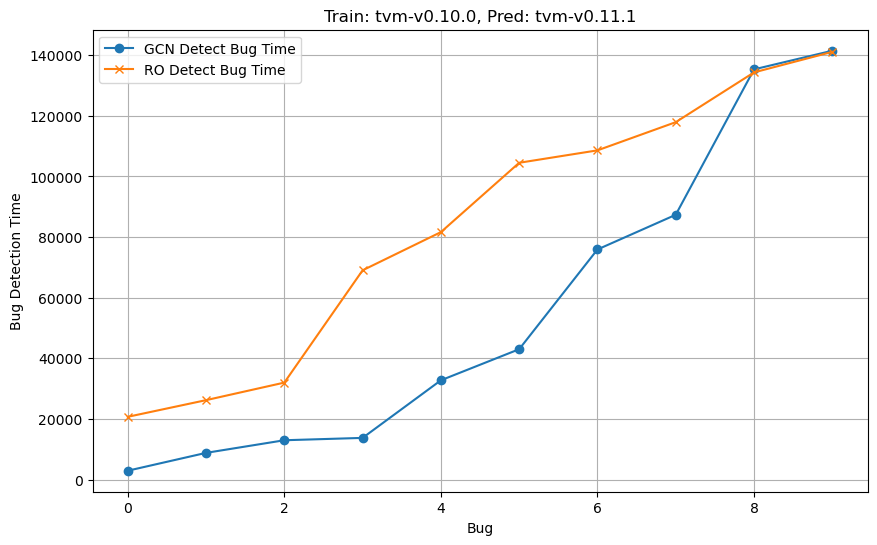

In [62]:
average_GCN_detect_bug_time = []
average_RO_detect_bug_time = []
for i in range(len(GCN_detect_bug_time_list)):
    average_GCN_detect_bug_time.append(0)
    average_RO_detect_bug_time.append(0)
for i in range(len(GCN_detect_bug_time_list)):
    for j in range(len(GCN_detect_bug_time_list_total)):
        average_GCN_detect_bug_time[i] += GCN_detect_bug_time_list_total[j][i]
        average_RO_detect_bug_time[i] += RO_detect_bug_time_list_total[j][i]
for i in range(len(GCN_detect_bug_time_list)):
    average_GCN_detect_bug_time[i] = average_GCN_detect_bug_time[i] / len(GCN_detect_bug_time_list_total)
    average_RO_detect_bug_time[i] = average_RO_detect_bug_time[i] / len(GCN_detect_bug_time_list_total)


# 创建图表
plt.figure(figsize=(10, 6))

# 绘制 GCN_detect_bug_time_list
plt.plot(average_GCN_detect_bug_time, label='GCN Detect Bug Time', marker='o')

# 绘制 RO_detect_bug_time_list
plt.plot(average_RO_detect_bug_time, label='RO Detect Bug Time', marker='x')

# 添加标题和标签
plt.title('Train: tvm-v0.10.0, Pred: tvm-v0.11.1')
plt.xlabel('Bug')
plt.ylabel('Bug Detection Time')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True)
plt.show()

In [63]:
import pickle
with open("gcn-tvm-v0.11.1-testdata_0_11.pkl", 'wb') as file:
    pickle.dump(average_GCN_detect_bug_time, file)